In [1]:
import copy
import sys
from typing import cast

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d.axes3d import Axes3D

sys.path.append("..")
sys.path.append("..")
from graph.utils import get_weighted_adjacency_matrix
from NGS.data import NGSDataset, add_noise, preprocess
from NGS.ema import EMA
from NGS.experiment import rollout
from NGS.hyperparameter import HyperParameter
from path import DATA_DIR, RESULT_DIR
from rossler.model import RosslerModel
from rossler.simulation import solve_rossler

plt.rcParams.update(
    {
        "font.family": "FreeSerif",
        "mathtext.default": "regular",
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
        "font.size": 20,
        "axes.titlesize": 20,
        "axes.labelsize": 20,
        "legend.fontsize": 20,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
    }
)

device = torch.device("cuda")

In [2]:
dataset = "rossler_train"
missing, noise = 0.1, 0.001

exp_id = f"rossler_p{missing}_s{noise}"
result_dir = RESULT_DIR / exp_id
hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")
assert hp.missing == missing
assert hp.noise == noise

# True trajectories
df = pd.read_pickle(DATA_DIR / f"{dataset}.pkl")
train, _ = preprocess(df, val_ratio=0.2)
true_trajectories = train["trajectories"]
eval_times = [np.insert(np.cumsum(dt), 0, 0.0) for dt in train["dts"]]

# Pred trajectories
pred_df = pd.read_pickle(result_dir / f"{dataset}.pkl")
pred_trajectories = pred_df["trajectories"]

# Lyapunov exponents
dop853_exponents = pd.read_pickle("DOP853_lyapunov.pkl")
ngs_exponents = pd.read_pickle(result_dir / "lyapunov.pkl")

# DOP853 nfevs/runtimes
df_int = pd.read_pickle(DATA_DIR / "rossler_test_int.pkl")
df_ext = pd.read_pickle(DATA_DIR / "rossler_test_ext.pkl")
dop853_nfevs = {"int": df_int.nfev.values, "ext": df_ext.nfev.values}
dop853_runtimes = {"int": df_int.runtime.values, "ext": df_ext.runtime.values}

# NGS nfevs/runtimes
df_int = pd.read_pickle(result_dir / "rossler_test_int.pkl")
df_ext = pd.read_pickle(result_dir / "rossler_test_ext.pkl")
ngs_nfevs = {"int": df_int.nfev.values, "ext": df_ext.nfev.values}
ngs_runtimes = {"int": df_int.runtime.values, "ext": df_ext.runtime.values}

### Single sample trajectory

In [3]:
sample_idx = 691

graph = df.graph[sample_idx]
eval_time = eval_times[sample_idx]
true_trajectory = true_trajectories[sample_idx]
pred_trajectory = pred_trajectories[sample_idx]

# Continuous trajectory
coupling = np.array(
    list(nx.get_edge_attributes(graph, "edge_attr").values()), dtype=np.float64
).squeeze()
adjacency = get_weighted_adjacency_matrix(graph, coupling)
params = df["glob_attr"][sample_idx].squeeze()
continuous_time = np.linspace(0.0, 40.0, 4001)
initial = true_trajectory[0]
continuous_trajectory, *_ = solve_rossler(adjacency, initial, continuous_time, params)


def plot_2d_trajectory(ax1: Axes, ax2: Axes, ax3: Axes, node: int, color: str) -> None:
    for i, ax in enumerate([ax1, ax2, ax3]):
        ax.plot(
            continuous_time,
            continuous_trajectory[:, node, i],
            color=color,
            linewidth=0.5,
        )
        ax.scatter(
            eval_time,
            true_trajectory[:, node, i],
            color=color,
            marker="o",
            s=60,
            facecolor="none",
        )
        ax.scatter(
            eval_time, pred_trajectory[:, node, i], color=color, marker="x", s=60
        )


def plot_3d_trajectory(ax: Axes3D, node: int, color: str) -> None:
    ax.plot(*continuous_trajectory[:, node, :].T, color=color, linewidth=0.5)
    ax.scatter(
        *true_trajectory[:, node, :].T,
        marker="o",
        s=60,
        color=color,
        facecolors="none",
        alpha=1.0
    )
    ax.scatter(*pred_trajectory[:, node, :].T, marker="x", s=60, color=color, alpha=1.0)

### Lyapunov exponent

In [4]:
def plot_exponents(ax: Axes, noise: float) -> None:
    ax.boxplot(
        np.stack([ngs_exponents[noise], dop853_exponents[noise]], axis=1),
        notch=True,
        widths=0.3,
        capwidths=0.2,
        medianprops={"color": "g"},
        flierprops={
            "marker": "o",
            "markerfacecolor": "none",
            "markeredgecolor": "g",
            "markersize": 10,
        },
    )
    ax.set_xticklabels([])
    ax.set_yticklabels([])


### Efficiency

In [5]:
# Plot settings
width = 0.15
ngs_locations = np.array([0.1, 0.6])
dop853_locations = ngs_locations + width
bar_kwargs = {"width": width, "capsize": 10, "align": "edge"}

def plot_efficiency(
    ax: Axes,
    ngs: dict[str, np.ndarray],
    dop853: dict[str, np.ndarray],
    colors: tuple[str, str],
) -> None:
    def zero_to_none(xs: list[float]) -> list[float] | None:
        return None if all(x == 0.0 for x in xs) else xs

    ax.bar(
        ngs_locations,
        [ngs["int"].mean(), ngs["ext"].mean()],
        yerr=zero_to_none(
            [
                1.96 * ngs["int"].std() / np.sqrt(len(ngs["int"])),
                1.96 * ngs["ext"].std() / np.sqrt(len(ngs["ext"])),
            ]
        ),
        color=colors[0],
        label="NGS",
        **bar_kwargs
    )
    ax.bar(
        dop853_locations,
        [dop853["int"].mean(), dop853["ext"].mean()],
        yerr=[
            1.96 * dop853["int"].std() / np.sqrt(len(dop853["int"])),
            1.96 * dop853["ext"].std() / np.sqrt(len(dop853["ext"])),
        ],
        color=colors[1],
        label="DOP853",
        **bar_kwargs
    )

    ax.tick_params(axis="x", length=0, labelsize=20)
    ax.set_xticks(
        dop853_locations,
        labels=[r"$\mathcal{G}_\text{int}$", r"$\mathcal{G}_\text{ext}$"],
    )


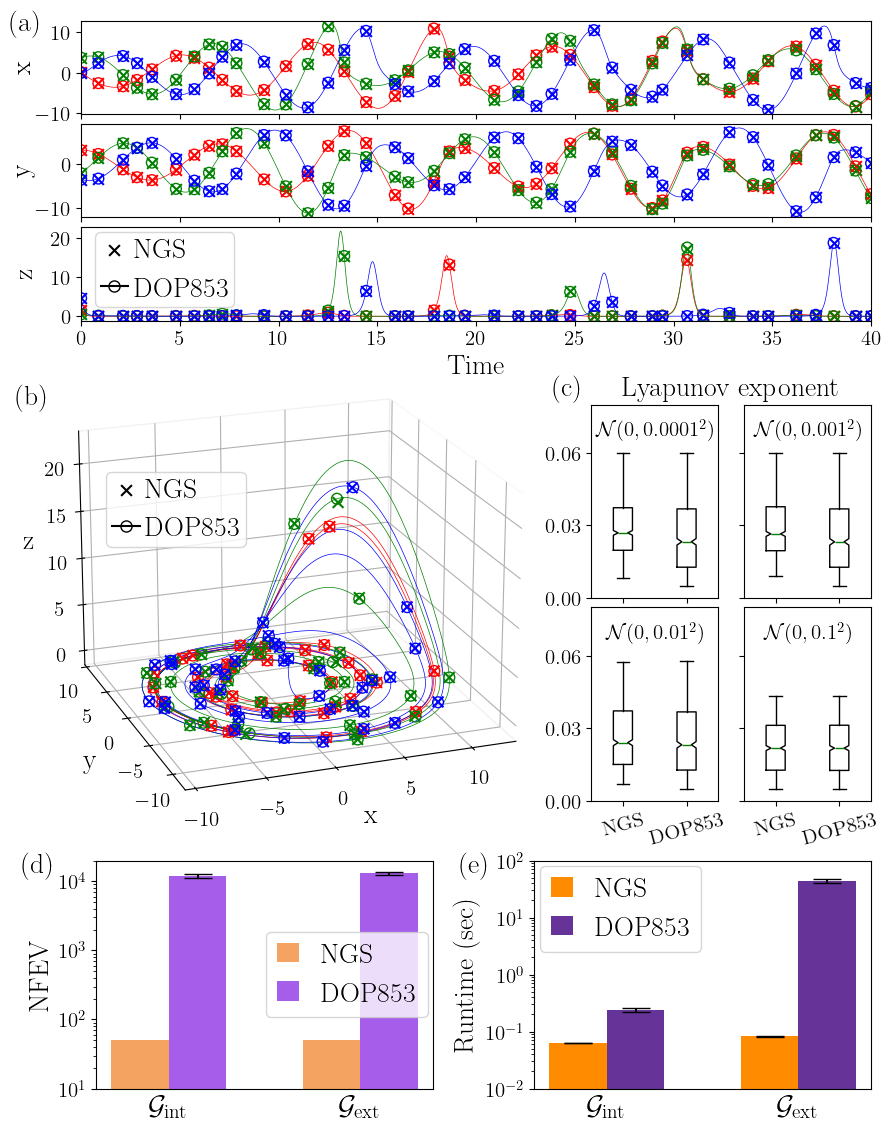

In [6]:
nodes = [17, 20, 59]
fig = plt.figure(figsize=(10, 12))

gs1 = GridSpec(3, 1, left=0.11, right=0.9, top=1.0, bottom=0.75, hspace=0.1)
gs2 = GridSpec(1, 1, left=0.05, right=0.58, top=0.80, bottom=0.25)
gs3 = GridSpec(2, 2, left=0.62, right=0.9, top=0.68, bottom=0.35, hspace=0.05)
gs4 = GridSpec(1, 2, top=0.3, wspace=0.3)
gs2.tight_layout(fig, pad=0.0)
gs3.tight_layout(fig, pad=0.0)
# gs4.tight_layout(fig, pad=0.0)

ax1 = fig.add_subplot(gs1[0, :])
ax2 = fig.add_subplot(gs1[1, :])
ax3 = fig.add_subplot(gs1[2, :])
ax4 = cast(Axes3D, fig.add_subplot(gs2[0, 0], projection="3d", zorder=-1))
ax4.view_init(elev=20, azim=-110, roll=0)
ax5 = fig.add_subplot(gs3[0, 0])
ax6 = fig.add_subplot(gs3[0, 1])
ax7 = fig.add_subplot(gs3[1, 0])
ax8 = fig.add_subplot(gs3[1, 1])
ax9 = fig.add_subplot(gs4[0, 0])
ax10 = fig.add_subplot(gs4[0, 1])

# 2D Trajectories
for node, color in zip(nodes, ["r", "g", "b"]):
    plot_2d_trajectory(ax1, ax2, ax3, node, color)

# 3D Trajectory
ax4.xaxis.pane.fill = False  # type:ignore
ax4.yaxis.pane.fill = False  # type:ignore
ax4.zaxis.pane.fill = False
for node, color in zip(nodes, ["r", "g", "b"]):
    plot_3d_trajectory(ax4, node, color)

# Lyaupunov exponents
plot_exponents(ax5, 0.0001)
plot_exponents(ax6, 0.001)
plot_exponents(ax7, 0.01)
plot_exponents(ax8, 0.1)

# Efficiency
plot_efficiency(ax9, ngs_nfevs, dop853_nfevs, ("sandybrown", "#A65DE9"))
plot_efficiency(ax10, ngs_runtimes, dop853_runtimes, ("darkorange", "rebeccapurple"))

# Legends
ax3.scatter([], [], marker="x", s=60, color="k", label="NGS")
ax3.plot([], [], "o-", markersize=8, color="k", label="DOP853", markerfacecolor="none")
ax3.legend(handletextpad=0.2, borderpad=0.2, handlelength=1.0)
ax4.scatter([], [], marker="x", s=60, color="k", label="NGS")
ax4.plot([], [], "o-", markersize=8, color="k", label="DOP853", markerfacecolor="none")
ax4.legend(
    bbox_to_anchor=(0.45, 0.75), handletextpad=0.2, borderpad=0.2, handlelength=1.0
)
ax9.legend(handlelength=0.8, borderaxespad=0.2)
ax10.legend(handlelength=0.8, borderaxespad=0.2, loc="upper left")

# Ticks
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_yticks([0.0, 10.0, 20.0])
ax4.set_xticks([-10.0, -5.0, 0.0, 5.0, 10.0])
ax4.set_yticks([-10.0, -5.0, 0.0, 5.0, 10.0])
ax4.set_zticks([0.0, 5.0, 10.0, 15.0, 20.0])  # type:ignore

for ax in [ax5, ax6, ax7, ax8]:
    ax.set_yticks([0.00, 0.03, 0.06])
    ax.set_ylim(0.0, 0.08)
ax5.set_yticklabels(["0.00", "0.03", "0.06"])
ax7.set_yticklabels(["0.00", "0.03", "0.06"])
ax7.set_xticklabels(["NGS", "DOP853"])
ax8.set_xticklabels(["NGS", "DOP853"])
ax7.tick_params(axis="x", rotation=15)
ax8.tick_params(axis="x", rotation=15)


# Labels
ax1.set_ylabel("x", labelpad=0.0)
ax2.set_ylabel("y", labelpad=0.0)
ax3.set_ylabel("z", labelpad=10.0)
ax3.set_xlabel("Time")
ax4.set_xlabel("x", labelpad=5.0)
ax4.set_ylabel("y", labelpad=5.0)
ax4.set_zlabel("z", labelpad=5.0)
ax9.set_ylabel("NFEV")
ax10.set_ylabel("Runtime (sec)")

# Limits, scales
ax1.set_xlim(0.0, 40.0)
ax2.set_xlim(0.0, 40.0)
ax3.set_xlim(0.0, 40.0)
ax9.set_ylim(1e1, 2e4)
ax10.set_ylim(1e-2, 1e2)
ax9.set_yscale("log")
ax10.set_yscale("log")

# Titles
ax5.set_title(r"$\mathcal{N}(0, 0.0001^2)$", fontsize=15, y=0.8)
ax6.set_title(r"$\mathcal{N}(0, 0.001^2)$", fontsize=15, y=0.8)
ax7.set_title(r"$\mathcal{N}(0, 0.01^2)$", fontsize=15, y=0.8)
ax8.set_title(r"$\mathcal{N}(0, 0.1^2)$", fontsize=15, y=0.8)
ax_ghost = fig.add_subplot(gs3[0, :])
ax_ghost.axis("off")
ax_ghost.set_title("Lyapunov exponent")

# Texts
ax1.text(-0.09, 0.9, "(a)", transform=ax1.transAxes)
ax4.text(0.0, 0.0, 205.0, "(b)", transform=ax4.transAxes)
ax5.text(-0.3, 1.05, "(c)", transform=ax5.transAxes)
ax9.text(-0.22, 0.95, "(d)", transform=ax9.transAxes)
ax10.text(-0.22, 0.95, "(e)", transform=ax10.transAxes)

fig.savefig("fig3.pdf", bbox_inches="tight")
fig.show()